In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import warnings

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [4]:
feat_names = [
    "area",
    "perimeter",
    "compactness",
    "length",
    "width",
    "asymmetry",
    "length_groove",
]

target_name = ["species"]

col_names = feat_names + target_name

<IPython.core.display.Javascript object>

In [5]:
# Data downloaded from:
# https://archive.ics.uci.edu/ml/datasets/seeds#
data_path = "seeds_dataset.tsv"
seeds = pd.read_csv(data_path, sep="\t+", header=None, names=col_names, engine="python")
seeds.head()

,area,perimeter,compactness,length,width,asymmetry,length_groove,species
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


<IPython.core.display.Javascript object>

In [6]:
class_labels = ["Kama", "Rosa", "Canadian"]
target_map = {i + 1: n for i, n in enumerate(class_labels)}
target_map

{1: 'Kama', 2: 'Rosa', 3: 'Canadian'}

<IPython.core.display.Javascript object>

In [7]:
seeds["species_name"] = seeds["species"].replace(target_map)
seeds.head()

,area,perimeter,compactness,length,width,asymmetry,length_groove,species,species_name
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1,Kama
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1,Kama
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1,Kama
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1,Kama
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1,Kama


<IPython.core.display.Javascript object>

## Viz

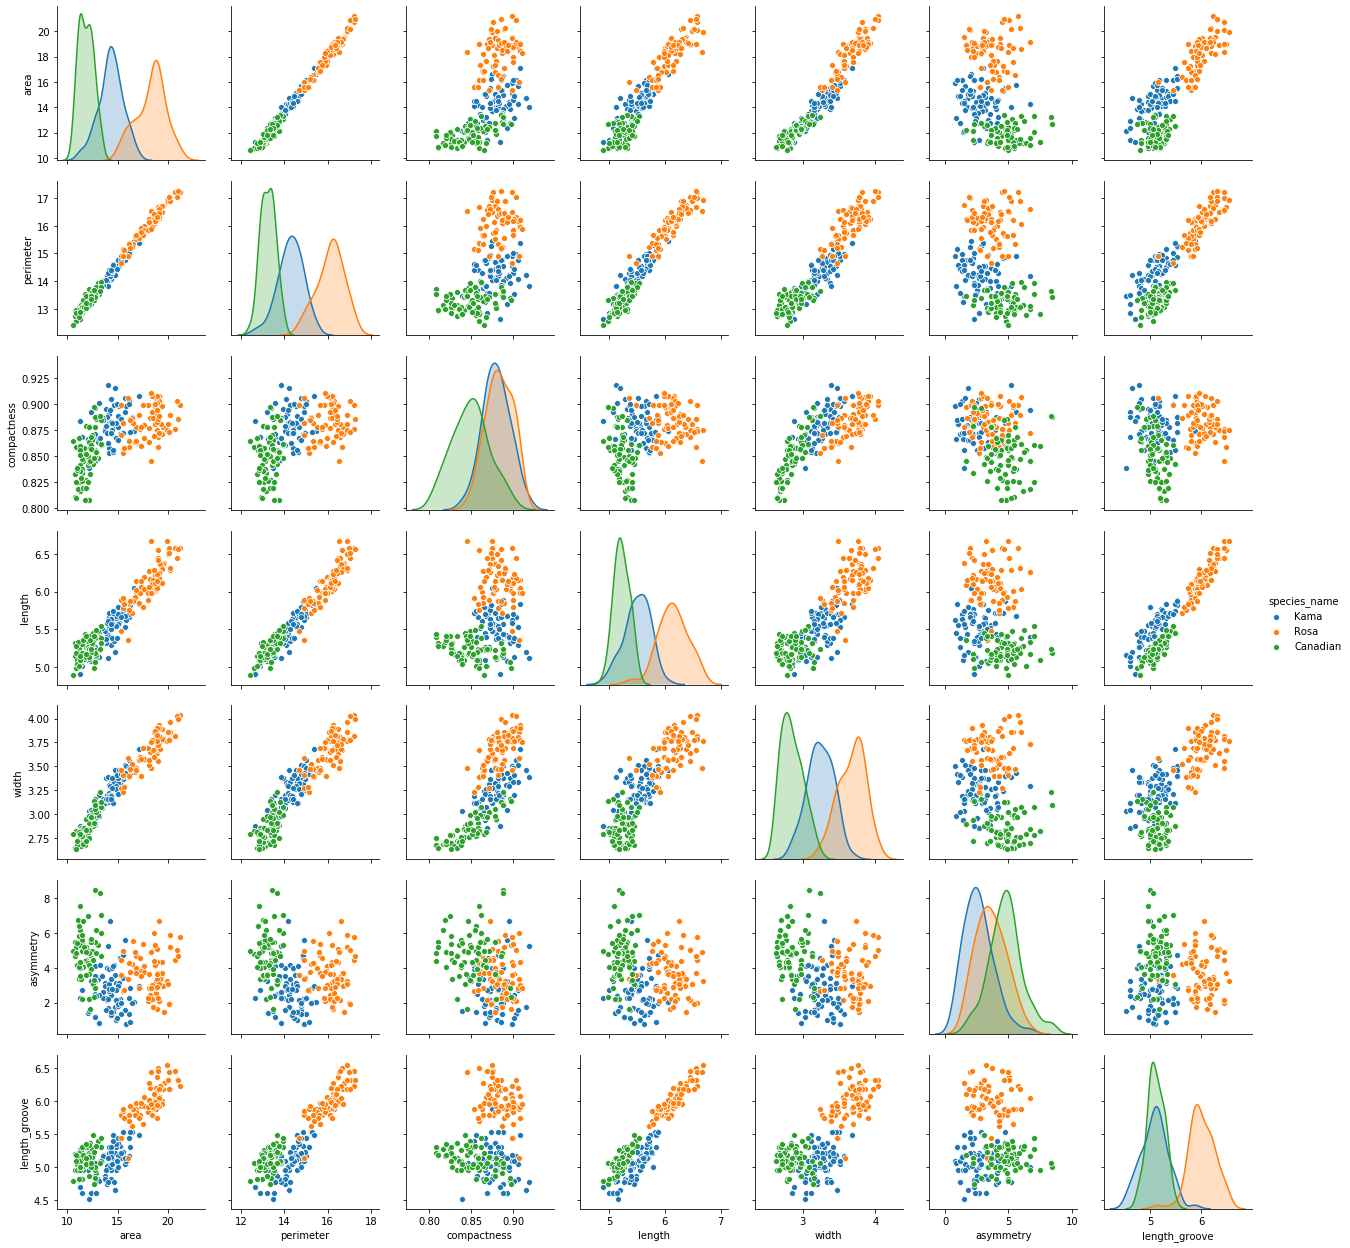

<IPython.core.display.Javascript object>

In [8]:
sns.pairplot(seeds.drop(columns="species"), hue="species_name")
plt.show()

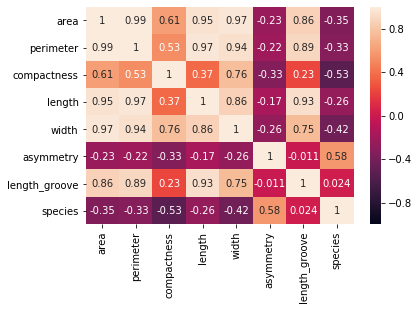

<IPython.core.display.Javascript object>

In [9]:
sns.heatmap(seeds.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

## Model prep

In [10]:
keep_cols = ["area", "asymmetry", "compactness", "species"]
seeds_sub = seeds[keep_cols]

<IPython.core.display.Javascript object>

In [11]:
X = seeds_sub.drop(columns=["species"])
y = seeds_sub["species"]

<IPython.core.display.Javascript object>

In [12]:
print_vif(X)

VIF results
-------------------------------
const          2063.375430
area              1.589552
asymmetry         1.125002
compactness       1.691643
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

<IPython.core.display.Javascript object>

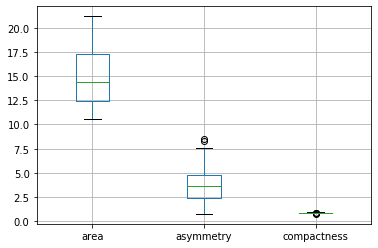

<IPython.core.display.Javascript object>

In [14]:
X_train.boxplot()
plt.show()

In [15]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, index=y_train.index, columns=X.columns)
X_test = pd.DataFrame(X_test, index=y_test.index, columns=X.columns)

<IPython.core.display.Javascript object>

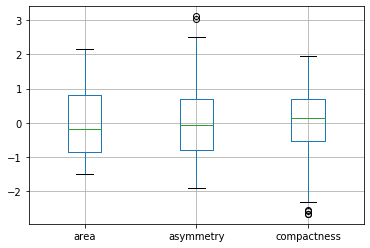

<IPython.core.display.Javascript object>

In [16]:
X_train.boxplot()
plt.show()

In [17]:
ks = range(1, 101)
grid = {"n_neighbors": ks}

model = GridSearchCV(KNeighborsClassifier(weights="distance"), grid)
model.fit(X_train, y_train)

best_k = model.best_params_["n_neighbors"]
print(f"best k: {best_k}")

best k: 19


<IPython.core.display.Javascript object>

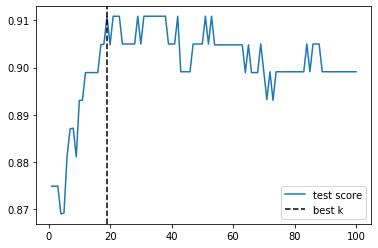

<IPython.core.display.Javascript object>

In [18]:
plt.plot(ks, model.cv_results_["mean_test_score"], label="test score")
plt.axvline(best_k, c="black", ls="--", label="best k")
plt.legend()
plt.show()

In [19]:
# Isolate just the best model, drop all the CV meta info
model = model.best_estimator_

<IPython.core.display.Javascript object>

In [20]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"train_score: {train_score}")
print(f"test_score: {test_score}")

train_score: 1.0
test_score: 0.8809523809523809


<IPython.core.display.Javascript object>

In [21]:
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[10  3  1]
 [ 1 13  0]
 [ 0  0 14]]
              precision    recall  f1-score   support

           1       0.91      0.71      0.80        14
           2       0.81      0.93      0.87        14
           3       0.93      1.00      0.97        14

    accuracy                           0.88        42
   macro avg       0.88      0.88      0.88        42
weighted avg       0.88      0.88      0.88        42



<IPython.core.display.Javascript object>

In [22]:
# Use kneighbors method to find what neighbors led to the prediction

# docs:
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.kneighbors

new_obs = X_test.iloc[[0], :]
prediction = model.predict(new_obs)[0]
print(f"predicted: {prediction} ('{target_map[prediction]}')")

dists, idxs = model.kneighbors(new_obs)

# sklearn works with numpy indices (aka not row names that pandas has)
# So we use iloc to find them instead of loc
neighbors_df = pd.DataFrame(X_train.iloc[idxs[0], :])
neighbors_df["dist"] = dists[0]

# Once we have this df, we can use pandas index info (aka row names)
# loc expects to see row names
neighbors_df["label"] = y[neighbors_df.index]
neighbors_df["label_name"] = seeds.loc[neighbors_df.index, "species_name"]

print("\n\nclosest k neighbors:")
display(neighbors_df)

predicted: 1 ('Kama')


closest k neighbors:


,area,asymmetry,compactness,dist,label,label_name
5,-0.175534,-0.801480,0.984272,0.444535,1,Kama
42,-0.596766,-0.802134,1.227674,0.453948,1,Kama
44,0.076515,-0.365796,1.131152,0.480682,1,Kama
3,-0.361981,-0.934278,1.001058,0.515687,1,Kama
7,-0.268758,-0.645785,0.816409,0.586626,1,Kama
199,-0.734875,-0.562050,1.038828,0.645322,3,Canadian
201,-0.765950,-0.907457,1.093383,0.689089,3,Canadian
124,0.380355,-0.229727,1.458485,0.722237,2,Rosa
35,0.425240,-0.927082,1.189904,0.722510,1,Kama
135,0.169738,-0.057023,1.147939,0.743269,2,Rosa


<IPython.core.display.Javascript object>